# EDA of DSC 20 Grades (Spring 2018)
*By [Daniel Lee](https://github.com/dleestat)*

---

## Introduction
DSC 20 (Programming and Basic Data Structures for Data Science) is an awesome data science course taught at UC San Diego. DSC 20 is taught using Python and a good portion of the course is spent building off of the concepts in its prerequisite course, DSC 10 (Principles of Data Science). This includes the use of the pandas library for big data processing. Course descriptions for DSC 10 and DSC 20 are [here](https://ucsd.edu/catalog/courses/DSC.html).

At the end of the course, grade breakdowns were released via CSV files (quite suitably). We were given a dataset. So of course, I'm going to analyze it.

We'll be analyzing student grades for the quarter I took this course, Spring Quarter 2018. Techniques we'll use include:
1. **Summary and descriptive statistics**
- **Correlation** (between students)
- **Prediction** (of final exam scores)
    1. **Ordinary least squares (OLS) regression**
    - **Stepwise OLS regression**
    - **Ridge regression**
    - **Lasso regression**
    - **Elastic net regression**
    - **Random forest regression**
    - **Gradient boosting trees regression**

## Syllabus
Taken from the [syllabus](https://sites.google.com/a/eng.ucsd.edu/dsc20-spring-2018/), below is the grade breakdown used for the calculation of the final course grade.

>- *30% Final Exam*
- *25% Homework Assignments*
- *15% Midterm Exam*
- *15% Labs*
- *10% Final Project*
- *5% Class Participation*

**Notes:**
- Since UCSD runs on the quarter system, the course consists of 10 weeks of instruction (referred to as Week 1, Week 2, etc.). A lab and a homework assignment were assigned every week, resulting in a total of 10 lab and homework assignments. The final project was due at the end of Week 10. The midterm exam was held during Week 5 and the final exam after Week 10.
- Students must have scored at least a 55% on the final exam to have passed the course.
- The lowest homework score was dropped. In addition, the 10th homework assignment was optional and replaced the lowest homework score if it benefited the student.
- The lowest lab score was dropped.
- Class participation is based on the percentage of lectures attended (monitored via iClickers). The first 6 missed lectures were dropped (i.e. not penalized for).

In [1]:
weeks = range(1,11)
final_exam_cutoff = .55

## Packages and Utilities
We'll first import and setup relevant libraries and utilities.

In [2]:
%%capture

# In alphabetical order:

from collections import namedtuple
import ipywidgets
from itertools import combinations  # Combinations (combinatorics)
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
plt.rcParams['patch.force_edgecolor'] = True
plt.style.use('ggplot')
%matplotlib inline

from natsort import natsorted  # Natural sorting
import numpy as np
import pandas as pd
pd.set_option('display.precision', 4)
pd.set_option('max_columns', 30)
pd.set_option('max_colwidth', 100)
pd.set_option('max_rows', 8)

import re  # Regular expressions
import scipy.stats as stats
import seaborn as sns
from sklearn import linear_model, ensemble
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import cross_validate, GridSearchCV, RandomizedSearchCV
import statsmodels.api as sm
import sys
import warnings

In [3]:
%%javascript

/* Disable auto-scrolling of long cell output */
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Data Import and Cleaning
We'll take a look at the raw dataset `Grades.csv`, then process the dataset into the most convenient format for our analysis.

### Raw Dataset

In [4]:
df_raw = pd.read_csv('Grades.csv')
df_raw

,Secrete Code,ants_bees_score,hw1_score,hw10_score,hw2_score,hw3_score,hw4_score,hw5_score,hw6_score,hw7_score,hw8_score,hw9_score,lab01_score,lab02_score,lab03_score,lab04_score,lab05_score,lab07_score,lab08_score,lab09_score,lab10_score,lab6_score,Midterm,Final,Participation,LAB_Total,HW_Total,Weighted_Total
0,vkk236,1.08,0.78,0.8,0.86,0.90,0.96,0.86,1.00,1.00,0.80,0.88,1.0,1.0,1.0,1.0,1.0,0.1,1.0,1.0,1.0000,1.0,0.9250,1.0444,0.8889,1.0000,0.9075,0.9814
1,blcrqj,1.08,0.94,0.6,0.93,0.88,0.99,0.93,0.90,0.87,0.93,0.95,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0000,1.0,0.8375,0.9667,1.0000,1.0000,0.9312,0.9564
2,bxc522,1.08,0.97,0.0,0.84,0.91,0.99,0.93,1.00,0.92,0.99,0.96,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0000,1.0,0.9125,0.9422,1.0000,1.0000,0.9588,0.9672
3,sghvkpdq,1.00,0.99,1.0,0.68,0.86,0.84,0.88,0.96,0.96,0.41,0.83,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.8571,1.0,0.9250,0.7889,0.6667,0.9841,0.9150,0.8851
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,da005706,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0000,0.0000,0.2222,0.0000,0.0000,0.0111
145,da005732,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0000,0.0000,1.0000,0.0000,0.0000,0.0500
146,da005687,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0000,0.0000,0.7778,0.0000,0.0000,0.0389
147,da005745,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0000,0.0000,0.9259,0.0000,0.0000,0.0463


The `Grades.csv` dataset contains all scores of all students. Scores are given as decimals (out of 1) rather than percentages. The raw dataset is not ordered in any discernible way.

**Selected Columns:**
- `Secrete Code` contains enciphered student ID's. For privacy, names and actual student ID's are not given.
- `ants_bees_score` contains final project scores (the final project was to program "Ants Vs. SomeBees", a custom implementation of the famous Plants vs. Zombies game).
- `Weighted_Total` contains final course grades.

### Cleaning

In [5]:
# Sort by final course grade
df = df_raw.sort_values('Weighted_Total', ascending=False).reset_index(drop=True)
df.index += 1

# Condense the 20 HW and Lab score columns into 2 single columns
hw_cols   = natsorted(filter(re.compile('hw\d+_score').match, df.columns))
lab_cols  = natsorted(filter(re.compile('lab\d+_score').match, df.columns))
df['HW']  = df[hw_cols].apply(lambda row: tuple(row), axis=1)
df['Lab'] = df[lab_cols].apply(lambda row: tuple(row), axis=1)

# Select and rename columns
df = df[['Secrete Code','Weighted_Total','Final','Midterm','HW_Total','LAB_Total','ants_bees_score','Participation','HW','Lab']]
df.rename({'Secrete Code':'ID','Weighted_Total':'Total','HW_Total':'HW_Avg','LAB_Total':'Lab_Avg','ants_bees_score':'Project'}, axis=1, inplace=True)
df

,ID,Total,Final,Midterm,HW_Avg,Lab_Avg,Project,Participation,HW,Lab
1,vkb218,1.0229,1.0778,0.9750,0.9813,1.0000,1.08,1.0000,"(1.0, 0.65, 0.98, 0.99, 0.93, 0.96, 0.98, 0.96, 0.98, 1.0)","(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0)"
2,gko011,1.0225,1.0889,0.9375,0.9888,1.0000,1.08,1.0000,"(1.0, 0.95, 0.98, 0.92, 1.0, 1.0, 0.96, 0.99, 0.98, 1.0)","(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0)"
3,zhc195,1.0097,1.1222,0.9375,0.9295,1.0000,1.00,1.0000,"(0.82, 0.91, 0.92, 0.97, 0.96, 0.99, 0.92, 0.9259999999999999, 0.84, 0.0)","(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0)"
4,mprxo,1.0046,1.1144,0.8875,0.9487,1.0000,1.00,1.0000,"(0.93, 0.89, 0.89, 0.97, 0.99, 1.0, 0.98, 0.86, 0.94, 0.0)","(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0)"
...,...,...,...,...,...,...,...,...,...,...
145,golx9999,0.0207,0.0000,0.0000,0.0000,0.1111,0.04,0.0000,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0)"
146,svsdkzd,0.0167,0.0000,0.0000,0.0000,0.1111,0.00,0.0000,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)"
147,blk317,0.0167,0.0000,0.0000,0.0000,0.1111,0.00,0.0000,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)"
148,da005706,0.0111,0.0000,0.0000,0.0000,0.0000,0.00,0.2222,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)"


This new dataset (stored in `df`) is now ordered by `Total`. Row indices now reflect student rankings (starting from 1).

**Columns:**
1. `ID` contains enciphered student ID's (if you're curious, mine is `gko011`).
- `Total` contains final course grades.
- `Final` contains final exam scores.
- `Midterm` contains midterm exam scores.
- `HW_Avg` contains homework score averages.
- `Lab_Avg` contains lab score averages.
- `Project` contains final project scores.
- `Participation` contains participation scores.
- `HW` contains homework scores.
- `Lab` contains lab scores.

There is one problem. The dataset contains all students who have been enrolled in the course *at any time*. Thus, the dataset may contain students who had dropped the course. This would skew our analysis.

Unfortunately, I don't have access to the resources (e.g. class rosters) to determine which students have dropped. However, we will use our best judgement to remove these students from our dataset.

Per [UCSD Academic Senate Regulations](http://senate.ucsd.edu/Operating-Procedures/Senate-Manual/Regulations/501), students were allowed to drop the course up to the end of Week 9. Keep in mind that the final exam was held after Week 10.

Thus, let's assume:

$$\text{A student received a nonzero score on the final exam.} \implies \text{The student did not drop the course.}$$

However, the converse is not necessarily true. There is a chance that an enrolled student missed the final exam due to an emergency or oversleeping (the exam was at 8 a.m. on a Saturday).

What we can do is start at the bottom of the rankings and work our way up until we find a student with a nonzero final exam score. Then we can assume that all the students below this student have dropped and all the students above (inclusive) have not dropped.

This process is illustrated below.

In [6]:
highlight = lambda row: ['background: lightyellow' if row.name == 120 
                         else 'background: seashell' if row.name > 123
                         else 'background: honeydew' for i in row]
df.loc[118:126].style.apply(highlight, axis=1)

,ID,Total,Final,Midterm,HW_Avg,Lab_Avg,Project,Participation,HW,Lab
118,jvfkzduw,0.657,0.5678,0.9,0.4088,0.7,1,0.8889,"(0.71, 0.09, 0.61, 0.29, 0.54, 0.89, 0.14, 0.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 1.0, 0.7, 1.0, 1.0, 0.6, 0.0, 1.0)"
119,b2pd,0.6455,0.4822,0.6125,0.65,0.9722,0.58,0.8519,"(0.65, 0.38, 0.86, 0.8, 0.0, 0.86, 0.96, 0.0, 0.69, 0.0)","(1.0, 1.0, 0.75, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5714285714285714)"
120,qlo021,0.6308,0,0.975,0.8494,1,1,0.4444,"(0.815, 0.53, 0.87, 0.97, 0.92, 0.92, 0.38, 0.93, 0.84, 0.0)","(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0)"
121,h3vdqwrv,0.6228,0.3244,0.4875,0.6825,0.8905,1,0.963,"(0.89, 0.5, 0.73, 0.73, 0.52, 0.67, 0.9, 0.16, 0.52, 0.0)","(1.0, 1.0, 1.0, 1.0, 0.7, 1.0, 1.0, 0.6, 0.3, 0.7142857142857143)"
122,clt016,0.6132,0.3033,0.7375,0.6475,0.9194,0.84,0.5556,"(0.62, 0.43, 0.69, 0.78, 0.79, 0.93, 0.24, 0.0, 0.7, 0.0)","(0.4, 1.0, 0.875, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0)"
123,uxihl,0.5687,0.2667,0.2625,0.7375,0.8778,1,0.6667,"(0.85, 0.1664, 0.73, 0.7, 0.89, 0.95, 0.22, 0.63, 0.93, 0.0)","(0.4, 1.0, 0.5, 1.0, 0.7, 1.0, 0.7, 1.0, 1.0, 1.0)"
124,phw016,0.3391,0,0.6125,0.4888,0.8333,0,0,"(0.83, 0.43, 0.17, 0.9, 0.71, 0.0, 0.39, 0.48, 0.0, 0.0)","(1.0, 1.0, 1.0, 0.2, 0.4, 1.0, 1.0, 1.0, 0.9, 0.0)"
125,bzfkhq,0.2712,0,0.5875,0.4475,0.475,0,0,"(0.87, 0.38, 0.74, 0.89, 0.7, 0.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 1.0, 0.875, 1.0, 0.4, 0.0, 0.0, 0.0, 0.0, 0.0)"
126,vwdnhjdp,0.1932,0,0.3875,0.3719,0.1199,0,0.4815,"(0.775, 0.48, 0.81, 0.91, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.4, 0.4545454545454545, 0.125, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)"


Above is an excerpt of the dataset with the 118th to 126th ranked students.

Here, students `phw016` and below (highlighted red) received a zero final exam score. `uxihl` is the lowest ranked student who received a nonzero final exam score. Thus, we assume that students `phw016` and below have dropped and students `uxihl` and above (highlighted green) have not dropped. Although `qlo021` (highlighted yellow) received a zero final exam score, we also assume that the student had not dropped since his/her ranking is above `uxihl`'s (in fact, `qlo021` is the only student above `uxihl` with a zero final exam score as seen below).

In [7]:
df.loc[df['Final']==0].head(1)  # Show top-ranked student with zero final exam score

,ID,Total,Final,Midterm,HW_Avg,Lab_Avg,Project,Participation,HW,Lab
120,qlo021,0.6308,0.0,0.975,0.8494,1.0,1.0,0.4444,"(0.815, 0.53, 0.87, 0.97, 0.92, 0.92, 0.38, 0.93, 0.84, 0.0)","(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0)"


We can validate our process on a case-by-case basis. All of the red-highlighted students received zeroes on their project score as well as their last few homework and lab scores, suggesting the students had dropped before these assignments were due. This pattern is not apparent in the green and yellow-highlighted students. Looking at `qlo021`, we can see that the student had received high midterm and assignment scores, suggesting that he/she had missed the final exam due to an emergency or oversleeping and not because he/she had dropped (a student who had received strong grades and had completed the last few assignments is very unlikely to have dropped).

We'll now apply this process to our dataset.

In [8]:
df = df.iloc[:-tuple(df['Final'] > 0)[::-1].index(True)]  # Remove students who dropped
df

,ID,Total,Final,Midterm,HW_Avg,Lab_Avg,Project,Participation,HW,Lab
1,vkb218,1.0229,1.0778,0.9750,0.9813,1.0000,1.08,1.0000,"(1.0, 0.65, 0.98, 0.99, 0.93, 0.96, 0.98, 0.96, 0.98, 1.0)","(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0)"
2,gko011,1.0225,1.0889,0.9375,0.9888,1.0000,1.08,1.0000,"(1.0, 0.95, 0.98, 0.92, 1.0, 1.0, 0.96, 0.99, 0.98, 1.0)","(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0)"
3,zhc195,1.0097,1.1222,0.9375,0.9295,1.0000,1.00,1.0000,"(0.82, 0.91, 0.92, 0.97, 0.96, 0.99, 0.92, 0.9259999999999999, 0.84, 0.0)","(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0)"
4,mprxo,1.0046,1.1144,0.8875,0.9487,1.0000,1.00,1.0000,"(0.93, 0.89, 0.89, 0.97, 0.99, 1.0, 0.98, 0.86, 0.94, 0.0)","(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0)"
...,...,...,...,...,...,...,...,...,...,...
120,qlo021,0.6308,0.0000,0.9750,0.8494,1.0000,1.00,0.4444,"(0.815, 0.53, 0.87, 0.97, 0.92, 0.92, 0.38, 0.93, 0.84, 0.0)","(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0)"
121,h3vdqwrv,0.6228,0.3244,0.4875,0.6825,0.8905,1.00,0.9630,"(0.89, 0.5, 0.73, 0.73, 0.52, 0.67, 0.9, 0.16, 0.52, 0.0)","(1.0, 1.0, 1.0, 1.0, 0.7, 1.0, 1.0, 0.6, 0.3, 0.7142857142857143)"
122,clt016,0.6132,0.3033,0.7375,0.6475,0.9194,0.84,0.5556,"(0.62, 0.43, 0.69, 0.78, 0.79, 0.93, 0.24, 0.0, 0.7, 0.0)","(0.4, 1.0, 0.875, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0)"
123,uxihl,0.5687,0.2667,0.2625,0.7375,0.8778,1.00,0.6667,"(0.85, 0.1664, 0.73, 0.7, 0.89, 0.95, 0.22, 0.63, 0.93, 0.0)","(0.4, 1.0, 0.5, 1.0, 0.7, 1.0, 0.7, 1.0, 1.0, 1.0)"


The dataset now contains 123 instead of 148 students after removing the 25 students who had dropped as per our process. Our dataset is now ready for analysis.

In [9]:
n = df.shape[0]  # Number of students in the final, cleaned dataset
n

123

## Summary and Descriptive Statistics

### Summary Statistics

In [10]:
df.describe()

,Total,Final,Midterm,HW_Avg,Lab_Avg,Project,Participation
count,123.0000,123.0000,123.0000,123.0000,123.0000,123.0000,123.0000
mean,0.8523,0.7751,0.7660,0.8588,0.9786,1.0091,0.8485
std,0.0994,0.1983,0.1647,0.1109,0.0475,0.1365,0.2497
min,0.5687,0.0000,0.0000,0.4006,0.7000,0.3000,0.0000
25%,0.7954,0.6633,0.6750,0.8062,0.9841,1.0000,0.7963
50%,0.8604,0.7889,0.8000,0.8975,1.0000,1.0800,0.9630
75%,0.9333,0.9183,0.8875,0.9350,1.0000,1.0800,1.0000
max,1.0229,1.1222,0.9750,0.9925,1.0000,1.0800,1.0000


Note: Some scores are above 1.0 due to extra credit.

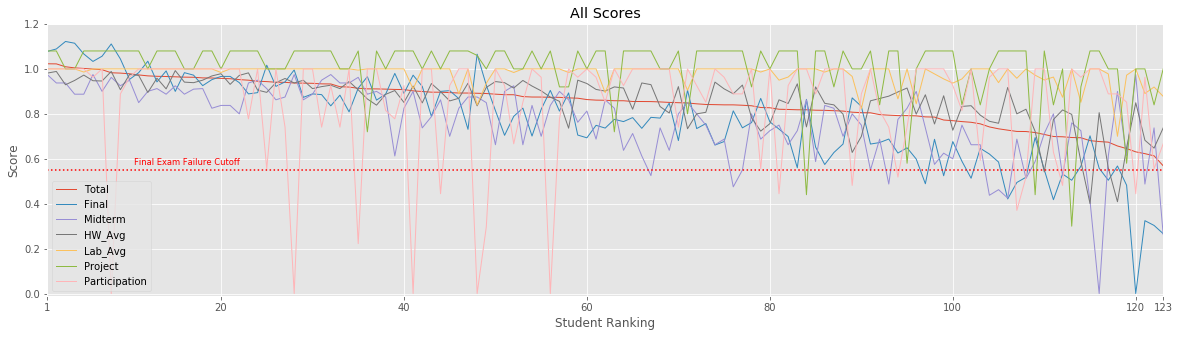

In [11]:
df.plot(figsize=(20,5), lw=1)
plt.title('All Scores')
plt.xlabel('Student Ranking')
plt.ylabel('Score')
plt.axis([1,n,-.01,1.2])
plt.xticks(list(range(20,n,20)) + [1,n])
plt.axhline(final_exam_cutoff, c='r', ls=':', lw=1.5)
plt.text(10.5, .575, 'Final Exam Failure Cutoff', color='r', size='small')
plt.legend(loc=3);

Unsurprisingly, there is a downward trend in most scores as student ranking descends. However, notice that `Participation` scores vary wildly with rankings (i.e. `Total`). We'll later see that there is almost no correlation between `Participation` and performance (e.g. `Final`).

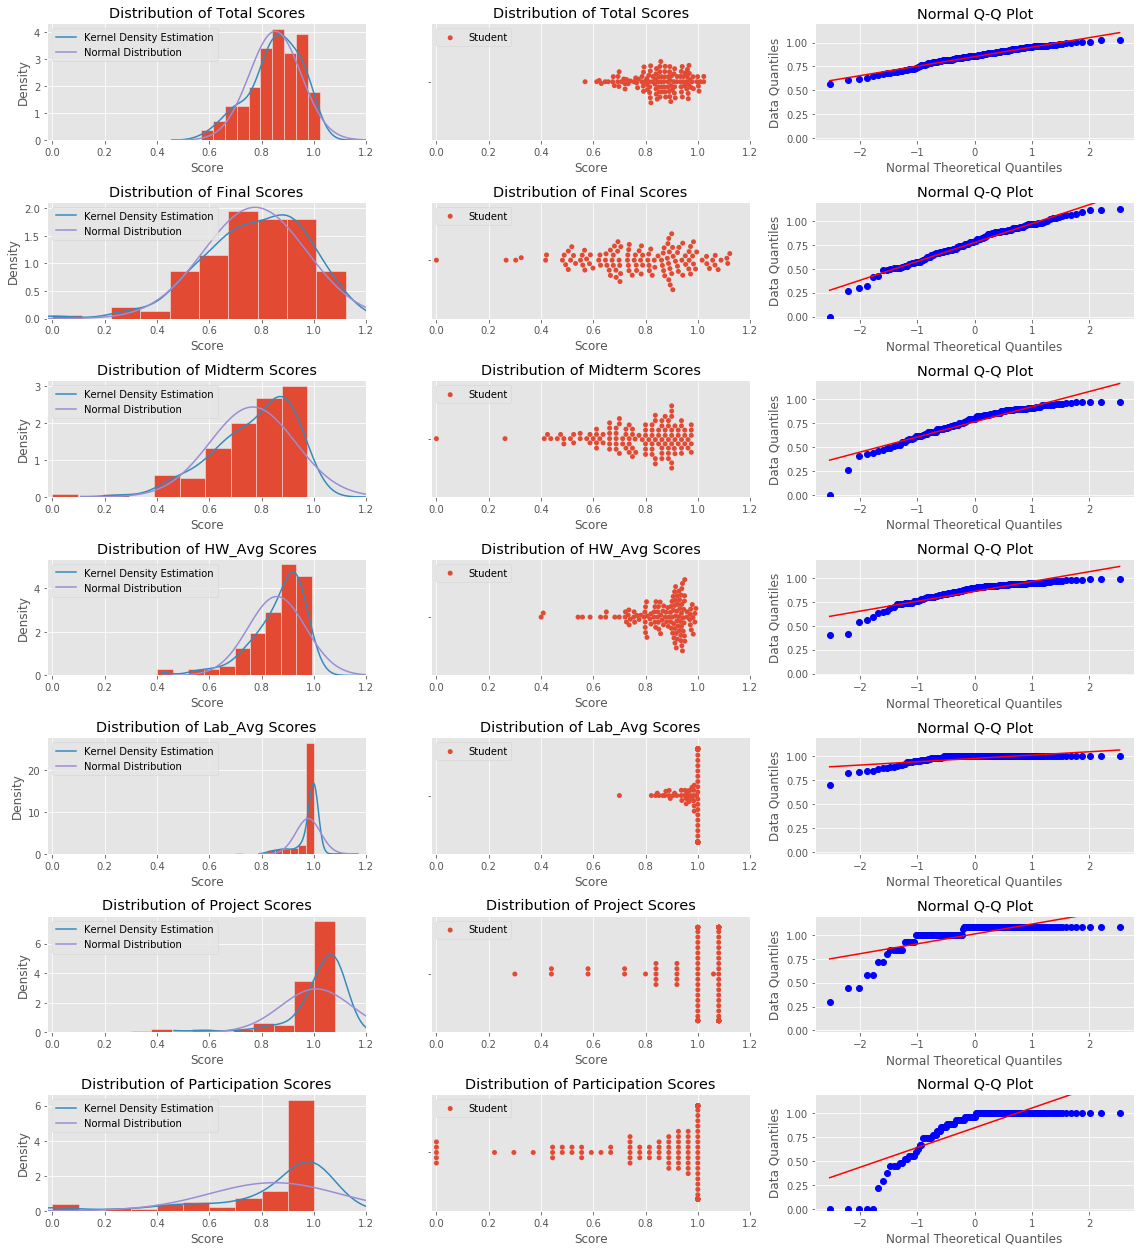

In [12]:
criteria = ('Total','Final','Midterm','HW_Avg','Lab_Avg','Project','Participation')
ncriteria = len(criteria)

plt.figure(figsize=(16,2.5*ncriteria))
lim = [-.02,1.2]

for i, criterion in enumerate(criteria,1):
    scores = df[criterion].values
    mean, sd = scores.mean(), scores.std()
    
    # Histogram
    plt.subplot(ncriteria, 3, 3*i-2)
    plt.hist(scores, density=True)
    x = np.linspace(mean-4*sd, mean+4*sd,100)
    plt.plot(x, stats.gaussian_kde(scores)(x), label='Kernel Density Estimation')
    plt.plot(x, stats.norm.pdf(x, loc=mean, scale=sd), label='Normal Distribution')
    plt.title('Distribution of {} Scores'.format(criterion))
    plt.xlabel('Score')
    plt.ylabel('Density')
    plt.xlim(lim)
    plt.legend(loc=2)
    
    # Swarm Plot
    plt.subplot(ncriteria, 3, 3*i-1)
    sns.swarmplot(scores, label='Student')
    plt.title('Distribution of {} Scores'.format(criterion))
    plt.xlabel('Score')
    plt.xlim(lim)
    plt.legend(loc=2)

    # Q-Q Plot
    plt.subplot(ncriteria, 3, 3*i)
    stats.probplot(scores, plot=plt)
    plt.title('Normal Q-Q Plot')
    plt.xlabel('Normal Theoretical Quantiles')
    plt.ylabel('Data Quantiles')
    plt.ylim(lim)

plt.tight_layout()

The `Total` and `Final` scores appear to be normally distributed. The `Midterm`, `HW_Avg`, `Lab_Avg`, `Project`, and `Participation` scores appear to have "backward" variations of the exponential distribution. It may be the case that these scores inherently come from an approximately normal distribution but that the top students' scores are "smooshed" along the upper bound. For example, it's impossible for students to have over a 1.0 `Participation` score, so the top students' scores appear to be condensed into a small range along the upper bound.

Notice that there are five students with a zero `Participation` score. Let's identify these students.

In [13]:
df.loc[df['Participation']==0]

,ID,Total,Final,Midterm,HW_Avg,Lab_Avg,Project,Participation,HW,Lab
8,fdr.fkhqcl97,0.9829,1.1111,0.9625,0.9888,1.0000,1.08,0.0,"(0.92, 0.79, 1.0, 0.99, 1.0, 1.0, 1.0, 1.0, 0.92, 1.0)","(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0)"
28,da005732,0.9373,0.9956,0.9750,0.9375,1.0000,1.08,0.0,"(0.0, 0.7, 0.81, 0.97, 0.99, 1.0, 0.98, 0.94, 0.81, 1.0)","(0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0)"
41,da005756,0.9023,0.9722,0.9000,0.9237,0.9111,1.08,0.0,"(0.0, 0.7, 0.81, 0.98, 0.96, 0.91, 0.96, 0.92, 0.85, 1.0)","(0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.2, 1.0, 1.0)"
48,qeotu1901,0.8917,1.0656,0.8750,0.8356,0.8389,1.06,0.0,"(0.0, 0.74, 0.78, 0.79, 0.56, 0.99, 0.97, 0.95, 0.665, 0.8)","(0.0, 0.0, 0.75, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0)"
56,vrqj4893,0.8736,0.9044,0.8375,0.8744,1.0000,1.08,0.0,"(0.0, 0.36, 0.86, 0.9, 0.93, 0.95, 0.96, 0.84, 0.755, 0.8)","(0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0)"


Surprisingly, these students received strong scores and are ranked highly, especially `fdr.fkhqcl97`. In fact, `fdr.fkhqcl97` received the third highest `Final` score in the class, beating the top two ranked students as seen below.

In [14]:
highlight = lambda row: ['background: lightyellow' if row.name == 8 else '' for i in row]
df[['ID','Total','Final']].sort_values('Final', ascending=False).iloc[:5].style.apply(highlight, axis=1)

,ID,Total,Final
3,zhc195,1.01,1.122
4,mprxo,1.005,1.114
8,fdr.fkhqcl97,0.9829,1.111
2,gko011,1.022,1.089
1,vkb218,1.023,1.078


Furthermore, `fdr.fkhqcl97` would have been the top ranked student if he/she received a full `Participation` score as seen below.

In [15]:
print("Top ranked student's Total:   {}".format(df['Total'].max()))
print("fdr.fkhqcl97's Total + .05:   {}".format(df.loc[df['ID']=='fdr.fkhqcl97', 'Total'].item() + .05))

Top ranked student's Total:   1.0228958333333331
fdr.fkhqcl97's Total + .05:   1.0328958333333333


So why did a top student receive a zero participation score? Maybe the student was so smart that he/she had no need to attend lectures.

There is a more plausible explanation. All of the lectures were podcasted online but students had to be physically present in order to receive participation credit. Thus, students could watch all of the lecture podcasts at any time or place, but would not receive credit unless they were physically present. This is likely the case with `fdr.fkhqcl97`.

Counterintuitive findings like this demonstrate the fickleness of participation as a predictor of a student's performance as we'll see later.

### Time Series

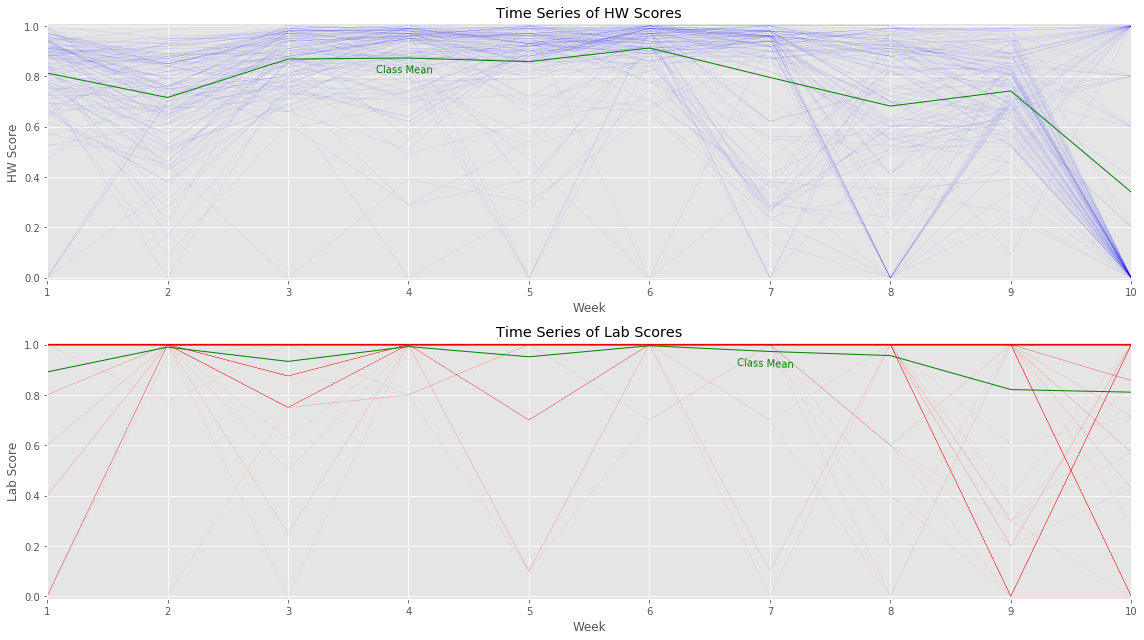

In [16]:
hw_mean  = tuple(map(np.mean,zip(*df['HW'])))
lab_mean = tuple(map(np.mean,zip(*df['Lab'])))

plt.figure(figsize=(16,9))
axis = [1,10,-.01,1.01]

# HW
plt.subplot(211)
plt.title('Time Series of HW Scores')
plt.xlabel('Week')
plt.ylabel('HW Score')
for student in df['HW'].values:
    plt.plot(weeks, student, 'b', lw=.05)
plt.plot(weeks, hw_mean, 'g', lw=1)
plt.text(3.73, .815, 'Class Mean', color='g', size='medium', rotation=-.5)
plt.axis(axis)
plt.xticks(weeks)

# Lab
plt.subplot(212)
plt.title('Time Series of Lab Scores')
plt.xlabel('Week')
plt.ylabel('Lab Score')
for student in df['Lab'].values:
    plt.plot(weeks, student, 'r', lw=.05)
plt.plot(weeks, lab_mean, 'g', lw=1)
plt.text(6.73, .918, 'Class Mean', color='g', size='medium', rotation=-2)
plt.axis(axis)
plt.xticks(weeks)

plt.tight_layout()

We can see that some weeks have drastic drops in homework and/or lab scores. I can offer the following plausible explanations:
- **Lab 1**: **Lab 1** was due on only the third day of the quarter and many students may have forgotten to complete the lab assignment.
- **HW 1**: **HW 1** served as a "warm-up" assignment, but the course staff graded **HW 2** much more aggressively, especially on doctests and code style, something many students overlooked for **HW 2**.
- **HW 8**: **HW 8** was considered the most difficult homework assignment (covering OOP, recursion, linked lists, queues, and circular arrays all in one assignment) and many students were unable to complete the assignment on time. **HW 7** was also difficult (covering time complexity and pandas).
- **HW 10**: As per the syllabus, **HW 10** was optional. 
- **Lab 10**: As per the syllabus, the lowest lab score was dropped and many students may have used the opportunity to skip **Lab 10**. This may also explain **Lab 9**.

Explanations are based off of my personal experience as well as what I observed during lectures and on the class' [Piazza](https://piazza.com) forum.

## Correlation Between Students

### Calculating Correlations
Academic integrity is something universities work hard to enforce and UCSD is no exception (I work for the Academic Integrity Office). For programming courses, special attention is given to programming assignments, as it's very easy for students to copy code from one another, whether intentionally or unintentionally. In some classes, students can work together as a pair. However, in DSC 20, any student collaboration on the homework assignments was considered cheating.

We'll use an algorithmic approach to explore correlations between students' homework scores and see if the correlations indicate any signs of cheating (i.e. signs of student collaboration).

We'll first generate all the possible student pairings (i.e. combinations of size 2) from our class. For example, in a class of three students (students **A**, **B**, and **C**), the possible pairings are:
1. **A** and **B**.
- **B** and **C**.
- **A** and **C**.

The number of the possible pairings for our class will be much larger.

For each pairing, we'll then calculate and store the correlation coefficient (via Pearson's r) between the two students' homework scores.

In [17]:
ID, HW = df['ID'].values, df['HW'].values

correlations = {}
for a, b in combinations(range(n), 2):  # Generates all combinations of size 2
    correlations[a,b] = stats.pearsonr(HW[a], HW[b])[0]

npairings = len(correlations)
print('There are {} possible student pairings from our class of {} students.'.format(npairings, n))

There are 7503 possible student pairings from our class of 123 students.


Proof: $\binom{123}{2}=\frac{123!}{2!(123-2)!}=7503$.

Now that we have all of the possible student pairings and their associated correlations, we'll store this data in a table.

In [18]:
df_r = pd.DataFrame(list(correlations.items()), columns=['Pairing','r'])
df_r['HWs']     = df_r['Pairing'].apply(lambda pair: (HW[pair[0]], HW[pair[1]]))
df_r['Pairing'] = df_r['Pairing'].apply(lambda pair: (ID[pair[0]], ID[pair[1]]))
df_r = df_r[['r','Pairing','HWs']].sort_values('r',ascending=False).reset_index(drop=True)
df_r.index += 1
df_r

,r,Pairing,HWs
1,0.9970,"(alc643, vlg015)","((0.97, 0.85, 0.94, 0.96, 0.96, 0.9, 0.96, 0.88, 0.81, 0.0), (0.97, 0.87, 0.99, 0.97, 0.97, 0.97..."
2,0.9960,"(cepdvrrg, h4gldc)","((0.81, 0.88, 0.9, 0.99, 0.94, 0.97, 1.0, 1.0, 0.755, 0.0), (0.83, 0.93, 0.92, 0.99, 0.98, 1.0, ..."
3,0.9943,"(fdr.fkhqcl97, bxc530)","((0.92, 0.79, 1.0, 0.99, 1.0, 1.0, 1.0, 1.0, 0.92, 1.0), (0.9, 0.7, 0.99, 1.0, 0.99, 0.98, 1.0, ..."
4,0.9941,"(da005732, da005756)","((0.0, 0.7, 0.81, 0.97, 0.99, 1.0, 0.98, 0.94, 0.81, 1.0), (0.0, 0.7, 0.81, 0.98, 0.96, 0.91, 0...."
...,...,...,...
7500,-0.6799,"(gko011, lvuxelr)","((1.0, 0.95, 0.98, 0.92, 1.0, 1.0, 0.96, 0.99, 0.98, 1.0), (0.565, 0.68, 0.66, 0.84, 0.47, 0.0, ..."
7501,-0.7348,"(odpffduw, odc021)","((0.855, 0.87, 0.8, 0.97, 0.93, 0.89, 0.94, 0.94, 0.94, 1.0), (0.95, 0.51, 0.69, 0.0, 0.27, 0.75..."
7502,-0.7649,"(vjp002, lvuxelr)","((0.88, 0.76, 0.86, 0.9, 0.9, 1.0, 0.95, 0.97, 0.87, 1.0), (0.565, 0.68, 0.66, 0.84, 0.47, 0.0, ..."
7503,-0.8393,"(odpffduw, fueurgb)","((0.855, 0.87, 0.8, 0.97, 0.93, 0.89, 0.94, 0.94, 0.94, 1.0), (0.76, 0.65, 0.79, 0.49, 0.62, 0.7..."


The table (stored in `df_r`) is ordered by `r`. Row indices reflect the ranking of `r` from strongest, positive correlation to strongest, negative correlation.

**Columns:**
1. `r` contains the correlation associated with each student pairing.
- `Pairing` contains the `ID`'s of the two students.
- `HWs` contains the `HW` scores of the two students.

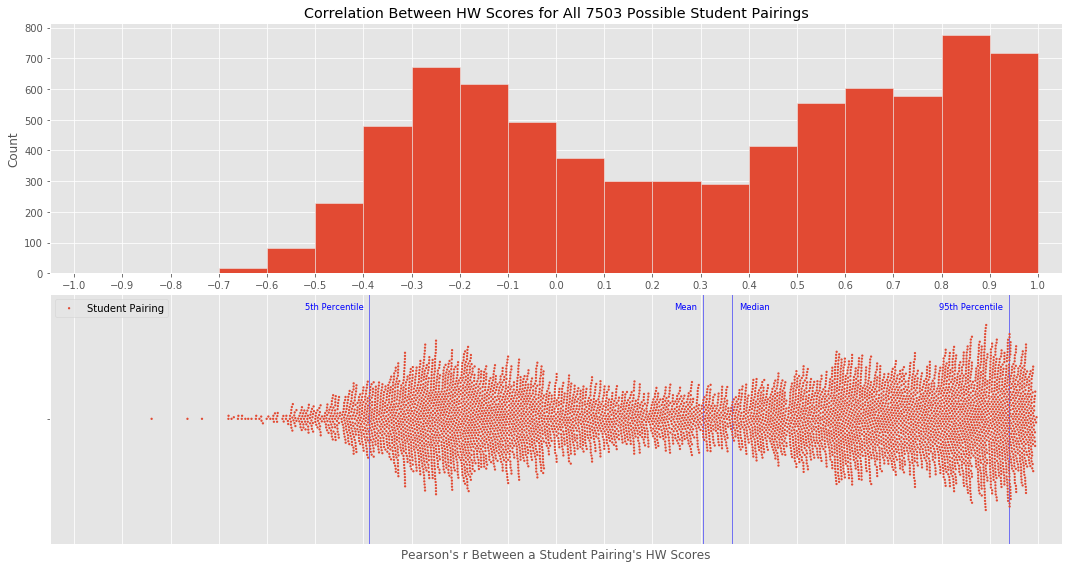

In [19]:
r = df_r['r'].values

plt.figure(figsize=(15,8))
xlim, xticks = [-1.05,1.05], np.arange(-1,1.1,.1)

# Histogram
plt.subplot(211)
plt.title("Correlation Between HW Scores for All {} Possible Student Pairings".format(npairings))
plt.ylabel('Count')
plt.hist(r, bins=xticks)
plt.xlim(xlim)
plt.xticks(xticks)

# Swarm Plot
plt.subplot(212)
plt.xlabel("Pearson's r Between a Student Pairing's HW Scores")
sns.swarmplot(r, size=2.3, label='Student Pairing')
plt.xlim(xlim)
plt.xticks(xticks)
plt.tick_params(axis='x', bottom=False, labelbottom=False)
plt.legend()

# Measures
Measure = namedtuple('Measure', 'name value xpos')
measures = (
    Measure('Mean', np.mean(r), .245),
    Measure('Median', np.median(r), .38),
    Measure('5th Percentile', np.percentile(r,5), -.52),
    Measure('95th Percentile', np.percentile(r,95), .795),
)

for measure in measures:
    plt.axvline(measure.value, c='b', lw=.5)
    plt.text(measure.xpos, -.44, measure.name, color='b', size='small')

plt.tight_layout(h_pad=0)

We can see two clusters of r's: one with weak, negative correlations and the other with strong, positive correlations. The distribution appears to be centered around a moderately strong, positive correlation. In general, we can see a very wide distribution of r's.

### Visualizing Correlations
Now that we have our correlations, let's visualize them.

We'll separate the 7503 correlations into four groups:
1. The strongest, positive correlations. This is the group we focus on.
- The "most average" correlations.
- The weakest correlations.
- The strongest, negative correlations.

The last three groups will serve as context for the first group.

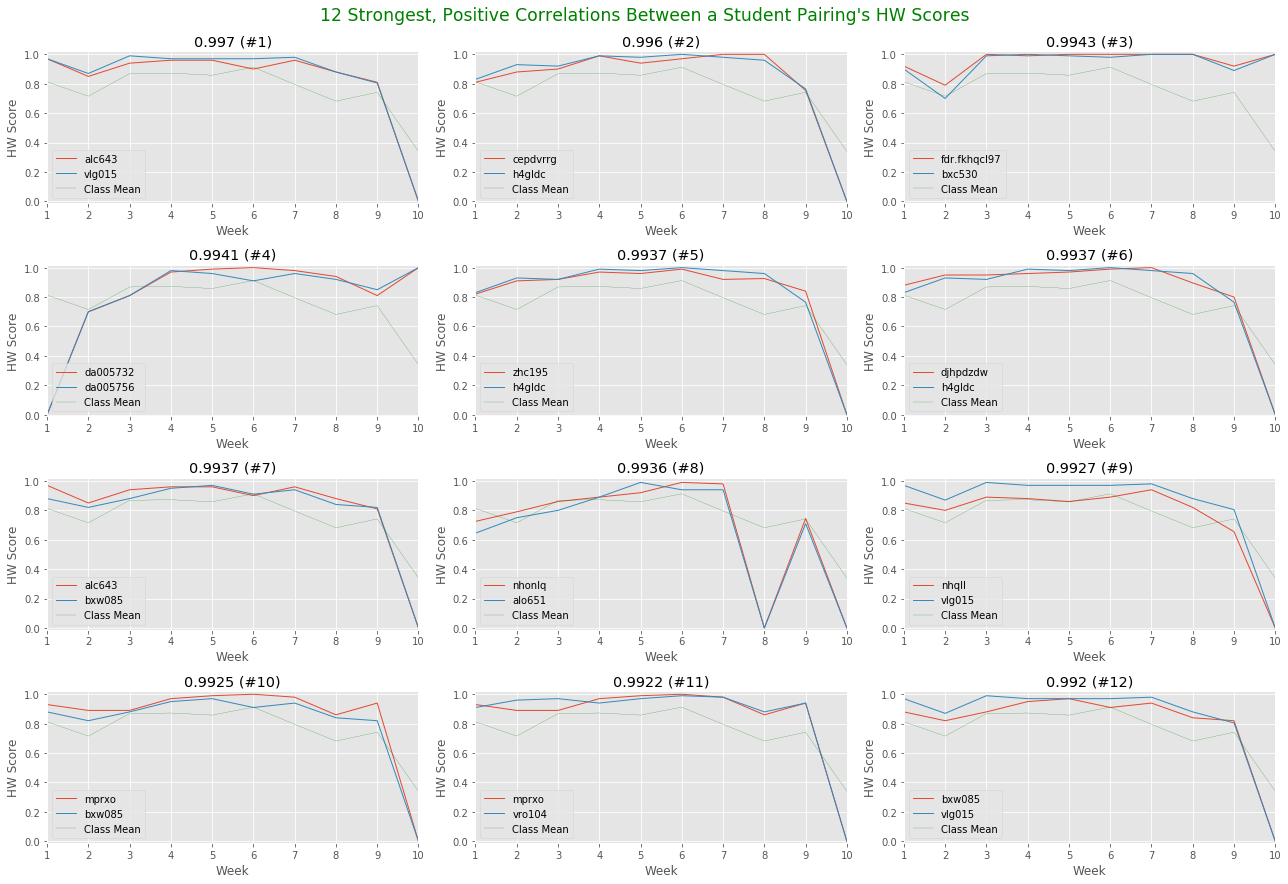

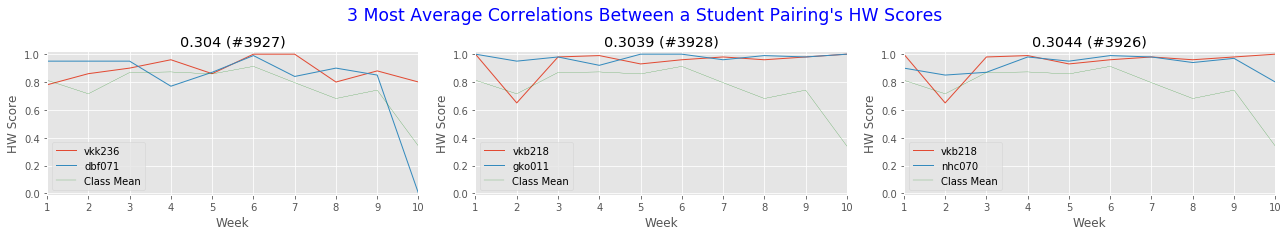

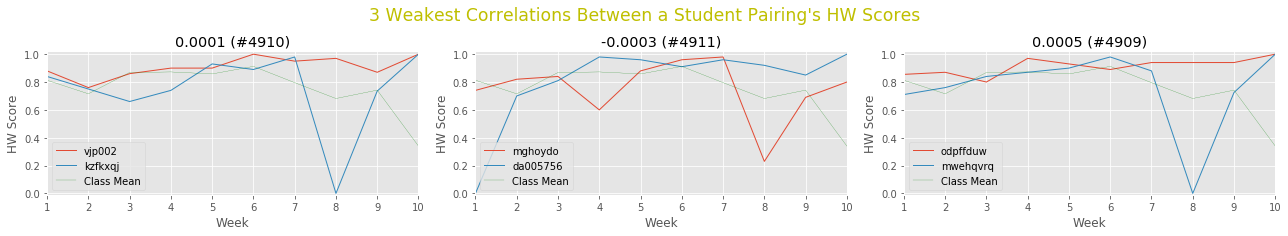

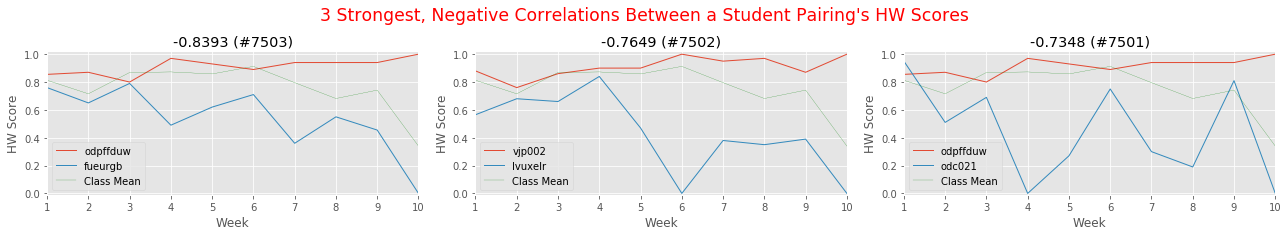

In [20]:
# Split into groups
rGroup = namedtuple('rGroup', 'name df title_color title_y')
groups = (
    rGroup('Strongest, Positive', df_r[:12], 'g', 1.02),
    rGroup('Most Average', df_r.assign(ab=abs(r-np.mean(r))).sort_values('ab').drop('ab',axis=1)[:3], 'b', 1.08),
    rGroup('Weakest', df_r.assign(ab=abs(r)).sort_values('ab').drop('ab',axis=1)[:3], 'y', 1.08),
    rGroup('Strongest, Negative', df_r[::-1][:3], 'r', 1.08),
)

# Visualize each group
for group in groups:
    nstudents = group.df.shape[0]
    
    plt.figure(figsize=(18,nstudents))
    plt.suptitle("{} {} Correlations Between a Student Pairing's HW Scores".format(nstudents, group.name), color=group.title_color, size='xx-large', y=group.title_y)
    for i in range(nstudents):
        pair = group.df.iloc[i]
        
        plt.subplot(nstudents/3,3,i+1)
        plt.title('{} (#{})'.format(round(pair['r'],4), pair.name))
        plt.xlabel('Week')
        plt.ylabel('HW Score')
        plt.plot(weeks, pair['HWs'][0], lw=1, label=pair['Pairing'][0])
        plt.plot(weeks, pair['HWs'][1], lw=1, label=pair['Pairing'][1])
        plt.plot(weeks, hw_mean, 'g', lw=.2, label='Class Mean')
        plt.axis([1,10,-.01,1.02])
        plt.xticks(weeks)
        plt.legend(loc=3)   
    
    plt.tight_layout()

We can see that the most average correlations illustrate a moderately positive association. This is unsurprising since we would expect the performance of the class to follow a general trend depending on factors such as homework assignment difficulty.

On the other hand, the strongest, positive correlations illustrate very strong positive associations. In some cases, we can even observe a correlation among idiosyncrasies (e.g. scores of zero), especially in pairing `#8`. 

Of course, these plots alone cannot "prove" that that a student pair had collaborated. Furthermore, we are unable to design any formal hypothesis tests, since we would first need a null distribution of the class with zero collaboration. However, this visualization serves as a useful reference nevertheless.

## Predicting Final Exam Scores

Up until now, we have only been exploring the data. We'll now turn to regression analysis and machine learning to make predictions using our data. In particular, we'll train a regression model to predict the final exam score of an unseen student based on his/her other scores.

Such a model may not only give us insight into our existing data, but may also be helpful for a student in a future quarter to estimate his/her final exam score based on the scores he/she had already received in the class.

We'll use feature selection and hyperparameter tuning to train several different regression models. After testing each model, we'll select the model that best balances accuracy and model simplicity.

### Feature Selection
We'll first take a look at all of our scalar variables and the relationships between them. Using this information, we'll eliminate the poor features.

CPU times: user 12.4 s, sys: 159 ms, total: 12.6 s
Wall time: 12.7 s


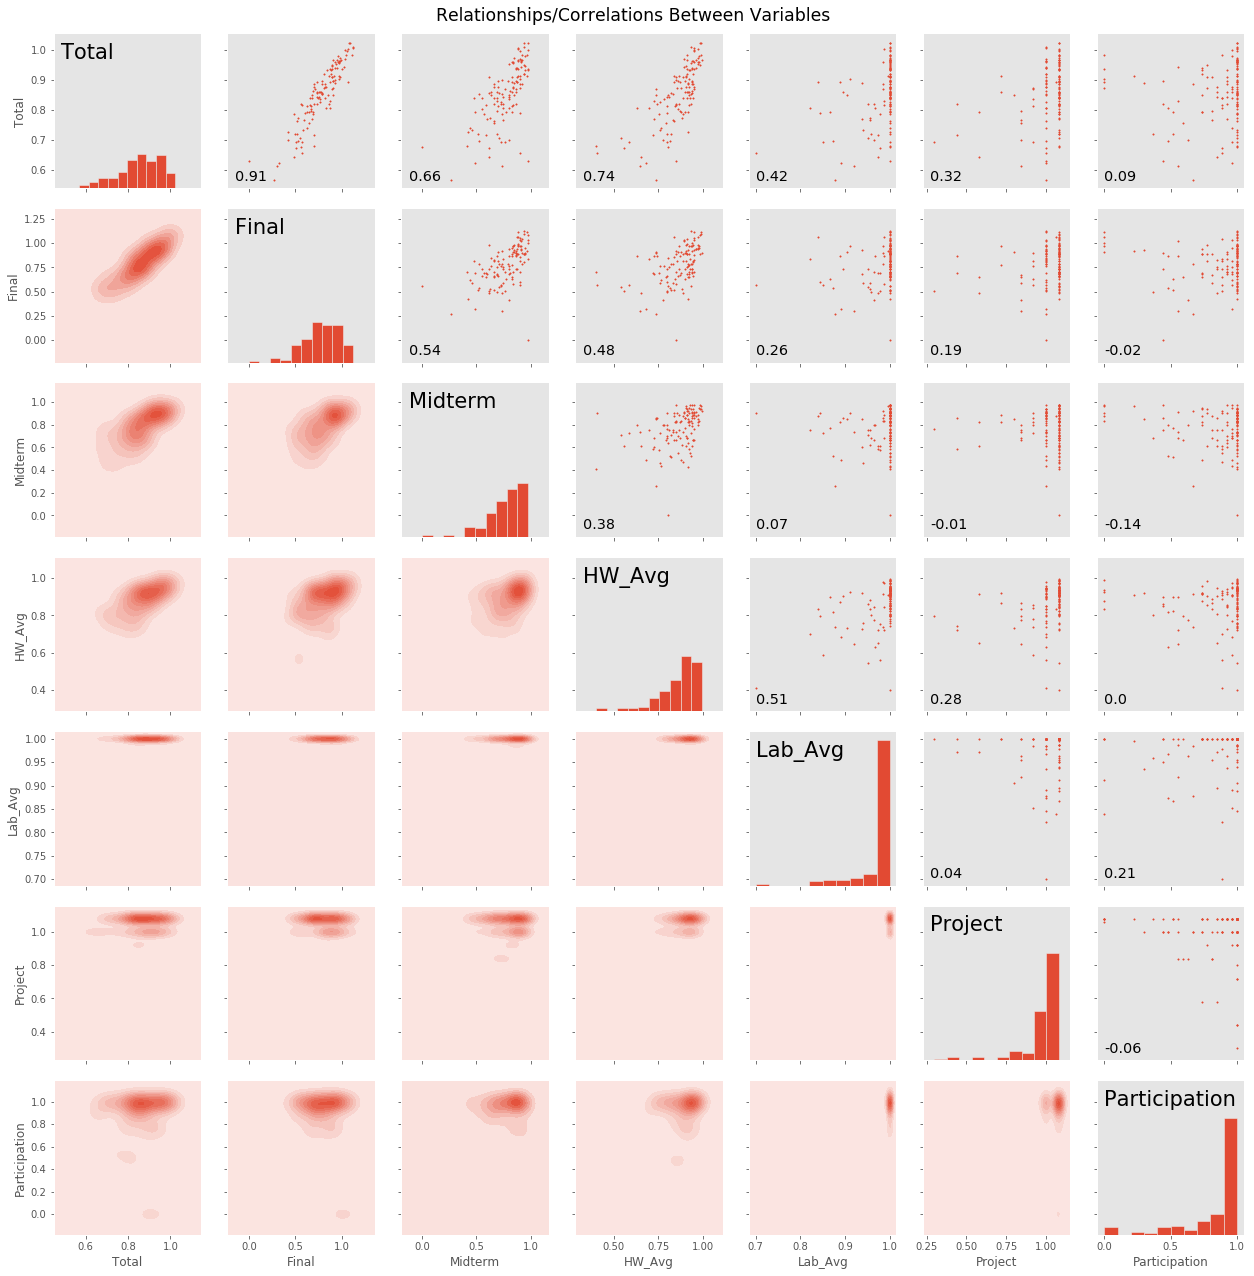

In [21]:
%%time

def add_r(x, y, **kwargs):
    """Add correlation to current Axes."""
    ax = plt.gca()
    ax.annotate(round(stats.pearsonr(x,y)[0], 2), xy=(.05,.05), xycoords=ax.transAxes, size='x-large')
    
def add_variable_name(x, **kws):
    """Add feature name to current Axes."""
    ax = plt.gca()
    ax.annotate(variables.pop(0), xy=(.05,.84), xycoords=ax.transAxes, size=21)

variables = list(criteria)

with plt.style.context({'axes.grid': False}), warnings.catch_warnings():
    warnings.simplefilter('ignore', category=FutureWarning)  
    g = sns.PairGrid(df[variables])
    plt.suptitle('Relationships/Correlations Between Variables', size='xx-large', y=1.01)
    g.map_upper(plt.scatter, s=2)
    g.map_upper(add_r)
    g.map_diag(plt.hist)
    g.map_diag(add_variable_name)
    g.map_lower(sns.kdeplot, shade=True)

To start off, we won't consider `Total` as a predictor due to the fact that a student won't know his/her `Total` score until after he/she has taken the final exam.

However, let's use this opportunity to observe the very weak correlation between `Participation` and `Total` as mentioned earlier, as well as between `Participation` and all other variables.

When focusing on the correlations between `Final` and the features, there is a fair amount of correlation except for between `Final` and `Participation`. Therefore, we won't consider `Participation` as a predictor.

We can observe a fair amount of collinearity between the features which may harm some or all of our models. Thus, we are going to build multiple models with the hopes that some of the models' algorithms will reduce this issue.

This leaves us with `Midterm`, `HW_Avg`, `Lab_Avg`, and `Project` as predictors for our target variable `Final`.

In [22]:
predictors = ['Midterm','HW_Avg','Lab_Avg','Project']
target = 'Final'

Before we proceed with our model building, we'll create a dataset with only our predictor and target variables, standardized.

We standardize for three reasons.

First, our data must be standardized for ridge, lasso, and elastic net regression in order for the shrinking of regression coefficients to be "fair" and not affected by different predictor scales.

Second, in future quarters, the distributions of scores may differ. We'll standardize our variables to ensure that our model focuses on *relative*, rather than *absolute*, performance.

For example, consider two hypothetical quarters:
- Quarter 1: Mean `Midterm` score of 0.8, standard deviation of 0.1. Student A receives a 0.9 `Midterm` score.
- Quarter 2: Mean `Midterm` score of 0.7, standard deviation of 0.1. Student B receives a 0.8 `Midterm` score.

If we built a model without standardizing our data (assuming a positive correlation between `Midterm` and `Final`), our model would likely predict student A to have a higher `Final` score than student B due to a higher *absolute* performance. However, when standardizing the scores, both students actually have the same *relative* performance (1 standard deviation above the mean) and thus ceteris paribus, our model will predict students A and B to have the same (standardized) `Final` score. By standardizing scores, we ensure our model focuses on relative performance.

In [23]:
df_z = df[predictors + [target]]
df_z = (df_z - df_z.mean()) / df_z.std()

###  Statistical Assumptions
There is one last step before we can proceed with our model building. Since some of our models will involve multiple linear regression, we'll need to check that our data satisfies the statistical assumptions for multiple linear regression.

There are three major assumptions that must be met for multiple linear regression:
1. **Linearity** (between each predictor and the target variable).
- **Normality** (of residuals)
- **Homoscedasticity** (of residuals)

#### Linearity
We can refer to the scatterplot matrix we generated earlier. There indeed appears to be a linear relationship between each predictor (`Midterm`, `HW_Avg`, `Lab_Avg`, `Project`) and `Final`.

#### Normality

To check the normality and homoscedasticity assumptions, we'll need to build a multiple linear regression model to analyze its residuals.

In [24]:
# Build an OLS model to check assumptions
OLS_checker = linear_model.LinearRegression().fit(df_z[predictors], df_z[target])

# Calculate its residuals
actual    = df_z[target]
predicted = OLS_checker.predict(df_z[predictors])
residuals = actual - predicted

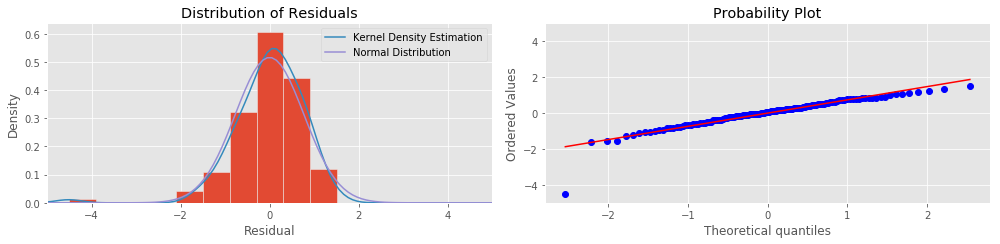

In [25]:
plt.figure(figsize=(14,3.5))
lim = [-5,5]

# Histogram
plt.subplot(121)
plt.title('Distribution of Residuals')
plt.xlabel('Residual')
plt.ylabel('Density')
plt.hist(residuals, density=True)
x = np.linspace(-5,5,100)
plt.plot(x, stats.gaussian_kde(residuals)(x), label='Kernel Density Estimation')
plt.plot(x, stats.norm.pdf(x, loc=residuals.mean(), scale=residuals.std()), label='Normal Distribution')
plt.xlim(lim)
plt.legend()

# Q-Q Plot
plt.subplot(122)
plt.title('Normal Q-Q Plot')
plt.xlabel('Normal Theoretical Quantiles')
plt.ylabel('Data Quantiles')
stats.probplot(residuals, plot=plt)
plt.ylim(lim)

plt.tight_layout()

According to the histogram and normal Q-Q plot above, the residuals appear to be approximately normally distributed.

#### Homoscedasticity

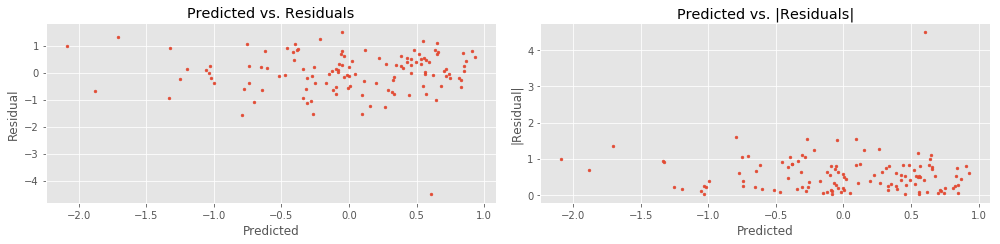

In [26]:
plt.figure(figsize=(14,3.5))

plt.subplot(121)
plt.title('Predicted vs. Residuals')
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.scatter(predicted, residuals, s=8)

plt.subplot(122)
plt.title('Predicted vs. |Residuals|')
plt.xlabel('Predicted')
plt.ylabel('|Residual|')
plt.scatter(predicted, abs(residuals), s=8)

plt.tight_layout()

According to the residual plots above, the residuals appear to be homoscedastic. Now that we have satisfied all three major assumptions for multiple linear regression, we are ready to start building our models.

### Model Building
We'll now build seven regression models:
1. **Ordinary least squares (OLS) regression**
- **Stepwise OLS regression**
- **Ridge regression**
- **Lasso regression**
- **Elastic net regression**
- **Random forest regression**
- **Gradient boosting trees regression**

Each model has its pros and cons in terms of bias, variance, overfitting, and handling of multicollinearity. Recall that our goal is to build a model that best balances accuracy and model simplicity. Each model will use a subset of our predictor set (`Midterm`, `HW_Avg`, `Lab_Avg`, `Project`) to predict `Final`.

We'll define a `Model` class and initialize all seven of our models using this class. Note that this class stores the number of folds (`nfolds`) and iterations (`niterations`) to be used for the k-fold cross validation we will perform later, during model testing.

In [27]:
class Model:
    """A model that predicts final exam scores.
    
    Class Attributes:
        nfolds:            Number of folds for k-fold cross validation.
        niterations:       Number of iterations of k-fold cross validation.
    
    Attributes:
        name (str):        Name of the model.
        predictors (list): The predictors of the model.
        MSEs (array):      The mean MSE's of each iteration of k-fold cross validation.
        r2s (array):       The mean r2's of each iteration of k-fold cross validation.  
        model:             The model.
    """
    nfolds, niterations = 10, 10
    
    def __init__(self, name, predictors=predictors):
        self.name, self.predictors = name, predictors
        self.MSEs, self.r2s = np.empty(Model.niterations), np.empty(Model.niterations)  # Placeholders

In [28]:
OLS            = Model('OLS')
OLS_stepwise   = Model('Stepwise OLS')
ridge          = Model('Ridge')
lasso          = Model('Lasso')
elastic_net    = Model('Elastic Net')
rf             = Model('Random Forest')
gbrt           = Model('Boosting Trees')

models = OLS, OLS_stepwise, ridge, lasso, elastic_net, rf, gbrt

Since an OLS regression model doesn't require any further feature selection or hyperparameter tuning, we can build the model right away.

In [29]:
OLS.model = linear_model.LinearRegression()

### More Feature Selection

Stepwise regression uses statistical criteria to select or eliminate features. In our case, our stepwise OLS regression model is the only model we'll perform further feature selection on.

In particular, we'll use backward elimination using t-test p-values as criteria, where:

$$H_0: \beta_i = 0$$
$$H_A: \beta_i \neq 0,$$

where $\beta_i$ represents a predictor's corresponding regression coefficient.

We're looking for predictors with low corresponding p-values, suggesting that the predictor is related to changes in `Final` and is thus a meaningful addition to the model. We'll keep eliminating predictors until all p-values are under the significance level $\alpha = 0.05$.

In [30]:
selected = predictors.copy()
sm.OLS(df_z[target], sm.add_constant(df_z[selected])).fit().summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
=================================================================
Model:              OLS              Adj. R-squared:     0.383   
Dependent Variable: Final            AIC:                294.6368
Date:               2018-09-16 23:25 BIC:                308.6977
No. Observations:   123              Log-Likelihood:     -142.32 
Df Model:           4                F-statistic:        19.90   
Df Residuals:       118              Prob (F-statistic): 1.52e-12
R-squared:          0.403            Scale:              0.61739 
-------------------------------------------------------------------
             Coef.    Std.Err.     t      P>|t|     [0.025   0.975]
-------------------------------------------------------------------
const        0.0000     0.0708   0.0000   1.0000   -0.1403   0.1403
Midterm      0.4541     0.0788   5.7641   0.0000    0.2981   0.6102
HW_Avg       0.2075     0.0957   2.1675   0.0322    0.0179   0.3970
Lab_Avg      0.1215     0.0845   1.4374   0.1533   -0.0459   0.2890
Project      0.1342     0.0755   1.7772   0.0781   -0.0153   0.2838
-----------------------------------------------------------------
Omnibus:             64.875       Durbin-Watson:          1.449  
Prob(Omnibus):       0.000        Jarque-Bera (JB):       385.275
Skew:                -1.690       Prob(JB):               0.000  
Kurtosis:            10.984       Condition No.:          2      
=================================================================

"""

Let's first eliminate `Lab_Avg`, as it has the highest p-value corresponding to its regression coefficient.

In [31]:
selected.remove('Lab_Avg')
sm.OLS(df_z[target], sm.add_constant(df_z[selected])).fit().summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
=================================================================
Model:              OLS              Adj. R-squared:     0.377   
Dependent Variable: Final            AIC:                294.7717
Date:               2018-09-16 23:25 BIC:                306.0204
No. Observations:   123              Log-Likelihood:     -143.39 
Df Model:           3                F-statistic:        25.62   
Df Residuals:       119              Prob (F-statistic): 7.41e-13
R-squared:          0.392            Scale:              0.62292 
-------------------------------------------------------------------
             Coef.    Std.Err.     t      P>|t|     [0.025   0.975]
-------------------------------------------------------------------
const        0.0000     0.0712   0.0000   1.0000   -0.1409   0.1409
Midterm      0.4343     0.0779   5.5738   0.0000    0.2800   0.5885
HW_Avg       0.2812     0.0811   3.4658   0.0007    0.1206   0.4419
Project      0.1182     0.0750   1.5756   0.1178   -0.0304   0.2668
-----------------------------------------------------------------
Omnibus:             59.367       Durbin-Watson:          1.373  
Prob(Omnibus):       0.000        Jarque-Bera (JB):       303.068
Skew:                -1.573       Prob(JB):               0.000  
Kurtosis:            10.017       Condition No.:          2      
=================================================================

"""

Let's then eliminate `Project` for the same reason.

In [32]:
selected.remove('Project')
sm.OLS(df_z[target], sm.add_constant(df_z[selected])).fit().summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
=================================================================
Model:              OLS              Adj. R-squared:     0.369   
Dependent Variable: Final            AIC:                295.3113
Date:               2018-09-16 23:25 BIC:                303.7479
No. Observations:   123              Log-Likelihood:     -144.66 
Df Model:           2                F-statistic:        36.73   
Df Residuals:       120              Prob (F-statistic): 3.59e-13
R-squared:          0.380            Scale:              0.63061 
-------------------------------------------------------------------
             Coef.    Std.Err.     t      P>|t|     [0.025   0.975]
-------------------------------------------------------------------
const        0.0000     0.0716   0.0000   1.0000   -0.1418   0.1418
Midterm      0.4185     0.0777   5.3833   0.0000    0.2646   0.5724
HW_Avg       0.3203     0.0777   4.1202   0.0001    0.1664   0.4742
-----------------------------------------------------------------
Omnibus:             57.078       Durbin-Watson:          1.266  
Prob(Omnibus):       0.000        Jarque-Bera (JB):       274.465
Skew:                -1.524       Prob(JB):               0.000  
Kurtosis:            9.653        Condition No.:          1      
=================================================================

"""

Now that all p-values are under $\alpha = 0.05$, let's build our stepwise OLS regression model. The final set of predictors for our stepwise OLS regression model consists of only `Midterm` and `HW_Avg`.

In [33]:
selected

['Midterm', 'HW_Avg']

In [34]:
OLS_stepwise.predictors = selected
OLS_stepwise.model = linear_model.LinearRegression()

### Hyperparameter Tuning

So far, we have built our first two models. Now, we'll tune the hyperparameters for the remaining five models.

We'll first define a function that'll help us with our hyperparameter tuning. This function uses the `GridSearchCV` function to return a model with the hyperparameter values which minimize the model's MSE loss function based on k-fold cross-validation results.

In [35]:
def tune(model, param_grid):
    """Return a model with tuned hyperparameters."""
    with warnings.catch_warnings():
        warnings.simplefilter('ignore', category=ConvergenceWarning)
        cv_results = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', n_jobs=-1, cv=Model.nfolds, verbose=1).fit(df_cv_tune[predictors], df_cv_tune[target])
        sys.stderr.write('\n{}'.format(cv_results.best_params_))
        return cv_results.best_estimator_

Since the folds in `GridSearchCV`'s k-fold cross-validation are not randomly selected by default, we'll create a shuffled dataset to use for cross-validation.

In [36]:
np.random.seed(0)
df_cv_tune = df_z.sample(frac=1)

Now we'll apply this function to each of our models. Note that the hyperparameters to tune differ across models.

If you're wondering why I have picked seemingly arbitrary hyperparameter values to test, it's because I have done prior testing and have found that these ranges of values appear to perform the best for each model.

#### Ridge Regression
$$P_\alpha(\beta) = \alpha \Vert\beta\Vert_2^2$$
Hyperparameters to tune:
- `alpha`: The regularization parameter $\alpha$ to weight the L2-norm. Higher values correspond to a higher smoothness constraint. A value of 0 results in an OLE regression model.

In [37]:
ridge.model = tune(linear_model.Ridge(),
                   {'alpha': np.linspace(0,100,1001)[1:]})

Fitting 10 folds for each of 1000 candidates, totalling 10000 fits


[Parallel(n_jobs=-1)]: Done 340 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 7840 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed:    5.0s finished

{'alpha': 26.900000000000002}

#### Lasso Regression
$$P_\alpha(\beta) = \alpha \Vert\beta\Vert_1$$
Hyperparameters to tune:
- `alpha`: The regularization parameter $\alpha$ to weight the L1-norm. Higher values correspond to a higher smoothness constraint. A value of 0 results in an OLE regression model.

In [38]:
lasso.model = tune(linear_model.Lasso(),
                   {'alpha': np.linspace(0,1,101)[1:]})

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.6s finished

{'alpha': 0.02}

#### Elastic Net Regression
$$P_{\alpha, r}(\beta) = \alpha \left( \frac{1-r}{2} \Vert\beta\Vert_2^2 + r \Vert\beta\Vert_1 \right)$$
Hyperparameters to tune:
- `alpha`: The regularization parameter $\alpha$ to weight the L1 and L2-norms. Higher values correspond to a higher smoothness constraint. A value of 0 results in OLE regression model.
- `l1_ratio`: The mixing parameter $r$ to balance the weighting of the L1 and L2-norms. A value of 0 results in a ridge regression model and a value of 1 results in a lasso regression model.

In [39]:
elastic_net.model = tune(linear_model.ElasticNet(),
                         {'alpha': np.linspace(0,1,51)[1:], 'l1_ratio': np.linspace(0,1,51)})

Fitting 10 folds for each of 2550 candidates, totalling 25500 fits


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 5680 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 14680 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 25500 out of 25500 | elapsed:   12.2s finished

{'alpha': 0.24, 'l1_ratio': 0.0}

Note that the `l1_ratio` is 0, meaning our elastic net regression model is simply a lasso regression model.

#### Random Forest Regression
Hyperparameters to tune:
- `max_depth`: The maximum depth of each tree.
- `max_features`: The number of features to consider when looking for the best split.
- `min_samples_leaf`: The minimum number of samples required to be at a leaf node.
- `min_samples_split`: The minimum number of samples required to split an internal node.

In [40]:
rf.model = tune(ensemble.RandomForestRegressor(n_estimators=100),
                {'max_depth': range(6,10), 'max_features': [2,3], 'min_samples_leaf': range(7,11), 'min_samples_split': range(7,11)})

Fitting 10 folds for each of 128 candidates, totalling 1280 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 852 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done 1280 out of 1280 | elapsed:   28.6s finished

{'max_depth': 7, 'max_features': 3, 'min_samples_leaf': 10, 'min_samples_split': 9}

#### Gradient Boosting Trees Regression
Hyperparameters to tune:
- `learning_rate`: Shrinks the contribution of each tree by `learning_rate`.
- `max_depth`: The maximum depth of each tree.
- `min_samples_leaf`: The minimum number of samples required to be at a leaf node.
- `min_samples_split`: The minimum number of samples required to split an internal node.

In [41]:
gbrt.model = tune(ensemble.GradientBoostingRegressor(n_estimators=100, max_features=2),
                  {'learning_rate': np.linspace(.01,.08,8), 'max_depth': range(2,5), 'min_samples_leaf': range(8,12), 'min_samples_split': range(8,12)})

Fitting 10 folds for each of 384 candidates, totalling 3840 fits


[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 1360 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 3360 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 3840 out of 3840 | elapsed:   14.3s finished

{'learning_rate': 0.03, 'max_depth': 2, 'min_samples_leaf': 10, 'min_samples_split': 11}

Now that all of our models are fully built, we'll test our models.

### Model Testing

We'll test our models using k-fold cross-validation with MSE and $r^2$ as testing criteria. In particular, for each model, we'll run 10 iterations of 10-fold cross-validation. 

For each model:
1. For each of the 10 iterations of cross-validation, we'll build 10 fits and produce their MSE's and $r^2$'s. At this point, we have 100 MSE's and $r^2$'s.
- For each of the 10 iterations of cross-validation, we'll average its MSE's and $r^2$'s. At this point, we have 10 MSE's and $r^2$'s.
- Finally, we'll average the 10 mean MSE's and r's to produce 1 overall MSE and $r^2$.

CPU times: user 13.3 s, sys: 90.6 ms, total: 13.4 s
Wall time: 11.7 s


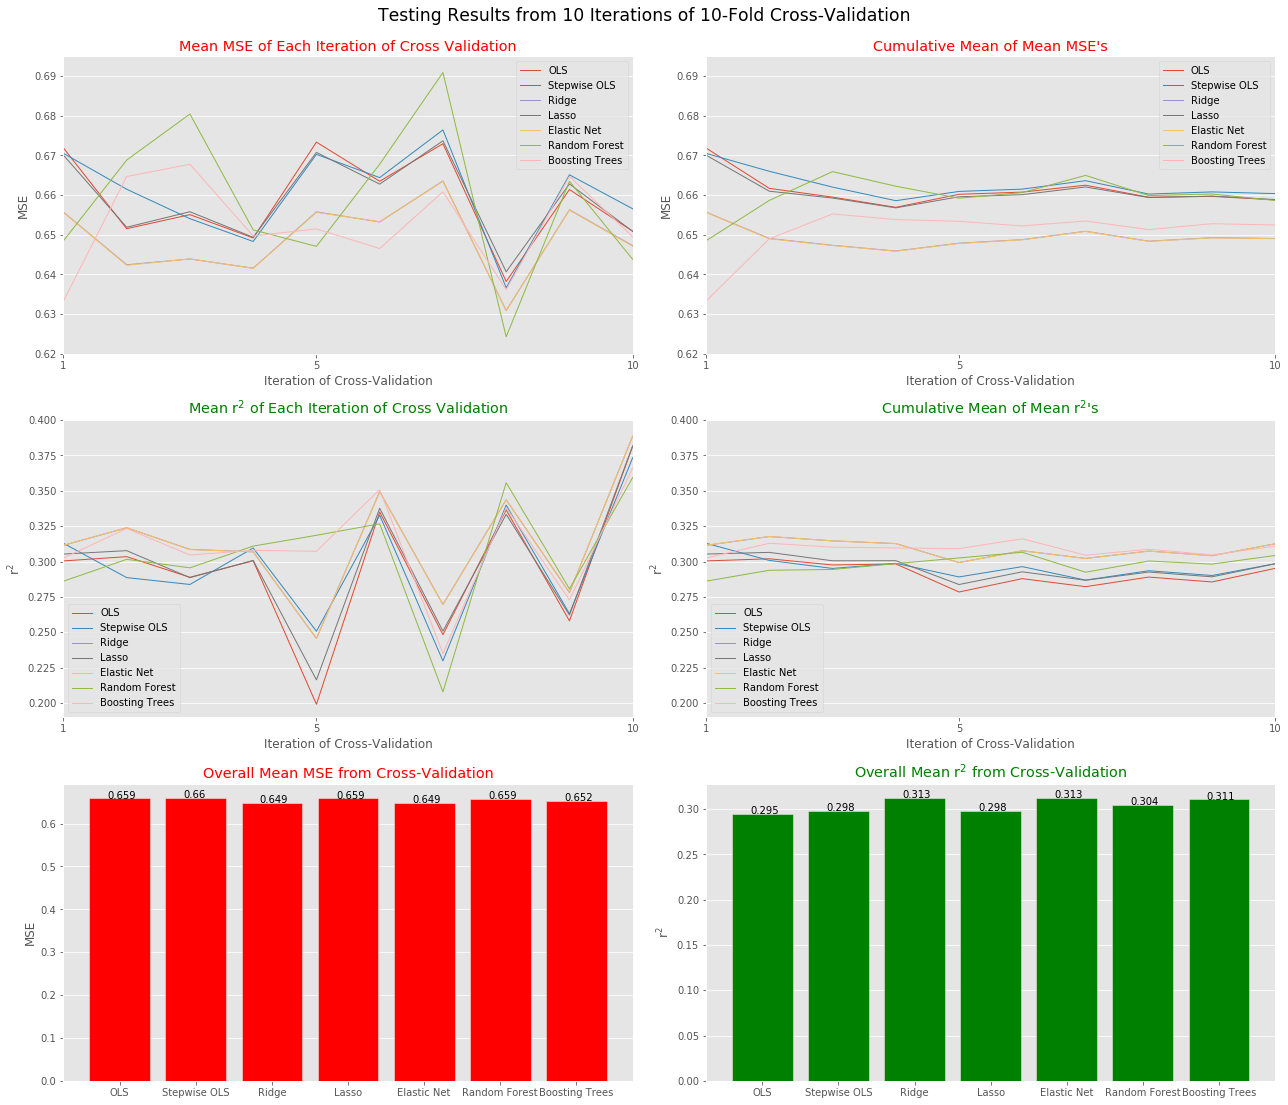

In [42]:
%%time

# Shuffle the data for cross validation
np.random.seed(0)
df_cvs = [df_z.sample(frac=1) for _ in range(Model.niterations)]

fig = plt.figure(figsize=(18,15))
plt.suptitle('Testing Results from {} Iterations of {}-Fold Cross-Validation'.format(Model.niterations, Model.nfolds), size='xx-large', y=1.02)
x = range(1, Model.niterations+1) 
xlim = [1, Model.niterations]
xticks = [1, Model.niterations//2, Model.niterations]
ylim_MSE, ylim_r2 = [.62,.695], [.19,.4]

MSE_mean_plt = plt.subplot(321)
plt.title('Mean MSE of Each Iteration of Cross Validation', color='r')
plt.xlabel('Iteration of Cross-Validation')
plt.ylabel('MSE')
plt.xlim(xlim)
plt.ylim(ylim_MSE)
plt.xticks(xticks)

MSE_cummean_plt = plt.subplot(322)
plt.title("Cumulative Mean of Mean MSE's", color='r')
plt.xlabel('Iteration of Cross-Validation')
plt.ylabel('MSE')
plt.xlim(xlim)
plt.ylim(ylim_MSE)
plt.xticks(xticks)

r2_mean_plt = plt.subplot(323)
plt.title('Mean r$^2$ of Each Iteration of Cross Validation', color='g')
plt.xlabel('Iteration of Cross-Validation')
plt.ylabel('r$^2$')
plt.xlim(xlim)
plt.ylim(ylim_r2)
plt.xticks(xticks)

r2_cummean_plt = plt.subplot(324)
plt.title("Cumulative Mean of Mean r$^2$'s", color='g')
plt.xlabel('Iteration of Cross-Validation')
plt.ylabel('r$^2$')
plt.xlim(xlim)
plt.ylim(ylim_r2)
plt.xticks(xticks)

MSE_overall_bar = plt.subplot(325)
plt.title('Overall Mean MSE from Cross-Validation', color='r')
plt.ylabel('MSE')

r2_overall_bar = plt.subplot(326)
plt.title('Overall Mean r$^2$ from Cross-Validation', color='g')
plt.ylabel('r$^2$')

for i, model in enumerate(models):
    # Generate mean MSE's and r's via cross-validation
    for iteration, df_cv in enumerate(df_cvs):
        with warnings.catch_warnings():
            warnings.simplefilter('ignore', category=ConvergenceWarning)
            scores = cross_validate(model.model, df_cv[model.predictors], df_cv[target],
                                    cv=Model.nfolds, scoring=['neg_mean_squared_error','r2'],
                                    return_train_score=False)
        model.MSEs[iteration] = -scores['test_neg_mean_squared_error'].mean()
        model.r2s[iteration]  = scores['test_r2'].mean()
    
    # Plot means
    MSE_mean_plt.plot(x, model.MSEs, lw=1, label=model.name)
    r2_mean_plt.plot(x, model.r2s, lw=1, label=model.name)
    
    # Calculate cumulative means
    MSE_cummean = np.cumsum(model.MSEs) / np.arange(1,Model.niterations+1)
    r2_cummean = np.cumsum(model.r2s) / np.arange(1,Model.niterations+1)
    
    # Plot cumulative means
    MSE_cummean_plt.plot(x, MSE_cummean, lw=1, label=model.name)
    r2_cummean_plt.plot(x, r2_cummean, lw=1, label=model.name)
    
    # Calculate overall means
    MSE_overall, r2_overall = model.MSEs.mean(), model.r2s.mean()
    
    # Plot overall means
    MSE_overall_bar.bar(model.name, MSE_overall, color='r')
    r2_overall_bar.bar(model.name, r2_overall, color='g')
    MSE_overall_bar.text(i-.16, MSE_overall, round(MSE_overall,3))
    r2_overall_bar.text(i-.16, r2_overall, round(r2_overall,3))
    
for ax in fig.get_axes():
    ax.xaxis.grid(False)
    
MSE_mean_plt.legend(loc=1)
r2_mean_plt.legend(loc=3)
MSE_cummean_plt.legend(loc=1)
r2_cummean_plt.legend(loc=3)
    
plt.tight_layout()

### Final Model
Let's use our stepwise OLS regression model to start making predictions.

We'll define the function `predict_final` that will take in any of our models and will print the predicted final exam score based on the inputted scores.

In [43]:
def predict_final(model, Midterm, HW_Avg, Lab_Avg, Project):
    """Print a student's predicted final exam score based on his/her previous scores."""
    assert model in models, 'model must be a valid model.'
    scores = [Midterm, HW_Avg] if model is OLS_stepwise else [Midterm, HW_Avg, Lab_Avg, Project]
    assert None not in scores, '{} regression requires {} scores.'.format(model.name, ' + '.join(model.predictors))
    
    print('{} regression with predictors: {}\n'.format(model.name, ' + '.join(model.predictors)))
    
    try:
        prediction = model.model.fit(df_z[model.predictors], df_z[target]).predict([scores])[0]
    except (TypeError, ValueError) as e:
        print('{}: Scores must be numbers, in standard units.'.format(type(e).__name__))
    print('Predicted final exam score: {} standard units'.format(round(prediction, 2)))

#### Predictions with Stepwise OLS Regression
Below is an interactive widget that will predict final exam score using our stepwise OLS regression model. We can move the sliders to make different predictions.

In [44]:
ipywidgets.interact(
    predict_final,
    model=ipywidgets.fixed(OLS_stepwise),
    Midterm=ipywidgets.FloatSlider(min=-3, max=3, step=.05),
    HW_Avg =ipywidgets.FloatSlider(min=-3, max=3, step=.05),
    Lab_Avg=ipywidgets.fixed(None),
    Project=ipywidgets.fixed(None)
);

interactive(children=(FloatSlider(value=0.0, description='Midterm', max=3.0, min=-3.0, step=0.05), FloatSlider…

Notice the effect of regression toward the mean. Even when inputting extreme `Midterm` and `HW_Avg` scores, the predicted `Final` regresses toward 0.

For example, a 3.0 `Midterm` score and a 3.0 `HW_Avg` score results in a predicted `Final` of only 2.22.

#### Predictions with Ridge Regression
Although our stepwise OLS regression model appears to be our best model, let's experiment with a model that uses four, rather than two features. Our ridge regression model appears to be a good candidate in terms of MSE, $r^2$, and model simplicity.

Below is a widget that will predict final exam score using our ridge regression model.

In [45]:
ipywidgets.interact(
    predict_final,
    model=ipywidgets.fixed(ridge),
    Midterm=ipywidgets.FloatSlider(min=-3, max=3, step=.05),
    HW_Avg =ipywidgets.FloatSlider(min=-3, max=3, step=.05),
    Lab_Avg=ipywidgets.FloatSlider(min=-3, max=3, step=.05),
    Project=ipywidgets.FloatSlider(min=-3, max=3, step=.05)
);

interactive(children=(FloatSlider(value=0.0, description='Midterm', max=3.0, min=-3.0, step=0.05), FloatSlider…

Regression toward the mean also applies here.

#### Caveats
Even with our careful data standardization, feature selection, hyperparameter tuning, and model selection, there are still some issues that may remain with our final models.

Standardizing our variables may reduce the issues of differing score distributions across quarters, but will not reduce the issue of differing importance of scores.

For example, we found that `Lab_Avg`, one of our predictors, did not have a strong (albeit moderate) correlation with `Final`. In a future quarter, labs may be much more difficult to receive a full score on and may be more indicative of a student's mastery of the course, translating to a higher `Final` score. Our current models do not have a way of addressing this issue.

However, our models appear robust and serve as a useful tool nevertheless.

## Conclusions

That's the end!

We were able to do so much with a very simple (yet "dirty") dataset. Through EDA, we were able to find some very peculiar and/or counterintuitive phenomena. For example, we found that a student's `Participation` is very weakly related to his/her overall performance in the class. In fact, `Participation` has a very weak, *negative* correlation with `Final`. For another example, we found that there appears to be two, rather than one, subpopulations in student pairings with regards to correlations between homework scores: one with weak, negative correlations and the other with strong, positive correlations.

Personally, from this EDA, I learned a lot about the underlying structure of class grades and I hope you did too.

Feel free to ask me any questions or to suggest any further EDA ideas regarding this dataset.